# Train-Test Split

In [1]:
import os
os.chdir(os.environ['PWD'])

Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from app.conf import settings as sts
from app.conf import utils as uts
from app.conf import model_utils as muts
from app.conf.mymodel import MyModel

In [3]:
import sys
sys.path.append('/Users/felipegonzalez/repos/colombian_food_prices/app')

#### Import Historical Data

In [4]:
dataset_filtered = uts.load_artifact('prices_dataframe', sts.LOCAL_ARTIFACTS_PATH)

#### Train-Test Split

In [5]:
train_dataset = dataset_filtered.loc[dataset_filtered['date'] < dataset_filtered['date'].max()].copy()
test_dataset = dataset_filtered.loc[dataset_filtered['date'] >= dataset_filtered['date'].max()].copy()

#### Save Splits as Artifacts

In [6]:
uts.dump_artifact(train_dataset, 'train_dataset', path=sts.LOCAL_ARTIFACTS_PATH)
uts.dump_artifact(test_dataset, 'test_dataset', path=sts.LOCAL_ARTIFACTS_PATH)

#### Train and Save Model with Training Set

In [7]:
train_model = uts.load_artifact('train_model', sts.LOCAL_ARTIFACTS_PATH)

In [8]:
train_model.get_model_info()

{'model_name': 'Next-Month Colombian Fruit and Veg Prices Predictor',
 'model_version': '1',
 'forecast_date': '2022-12'}

#### Compute MAPE from True and Pred Price on Test Set

In [9]:
test_dataset['pred_price'] = test_dataset.apply(lambda x: train_model.predict_product_market(x['product'], x['market']), axis = 1).apply(lambda x: x.get('point'))

In [10]:
test_dataset['mape'] = (abs(test_dataset['mean_price'] - test_dataset['pred_price']) / test_dataset['mean_price']).astype(float)

In [11]:
mape_df = test_dataset[['product', 'market', 'mape', 'mean_price', 'pred_price']].drop_duplicates()

In [12]:
mape_df.sort_values('mape',inplace=True)

#### Best Performing Price Prediction (lowest MAPE)

In [13]:
filtered_dataset = dataset_filtered.loc[
    (dataset_filtered['product'] == mape_df['product'].iloc[0]) &
    (dataset_filtered['market'] == mape_df['market'].iloc[0])
].set_index('date').dropna()
pred = mape_df['pred_price'].iloc[0]
true = mape_df['mean_price'].iloc[0]

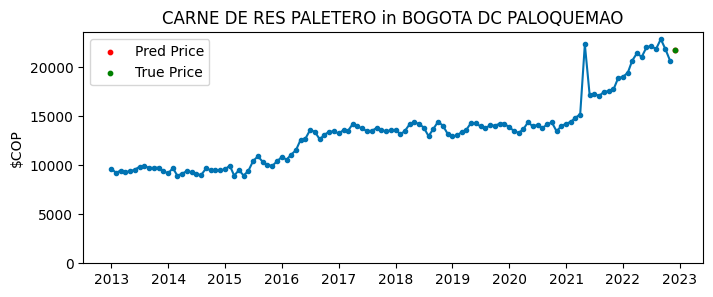

In [14]:
plt.figure(figsize=(8,3))
plt.plot(filtered_dataset['mean_price'].iloc[:-1], marker = '.')
plt.ylim(bottom=0)
plt.title(f"{mape_df['product'].iloc[0].upper()} in {mape_df['market'].iloc[0].upper()}")
plt.ylabel("$COP")
plt.scatter([filtered_dataset['mean_price'].index[-1]], [pred], s = 10, color = 'r', label = 'Pred Price')
plt.scatter([filtered_dataset['mean_price'].index[-1]], [true], s = 10, color = 'g', label = 'True Price')
plt.legend()
plt.show()

#### Worst Performing Price Prediction (highest MAPE)

In [15]:
filtered_dataset = dataset_filtered.loc[
    (dataset_filtered['product'] == mape_df['product'].iloc[-1]) &
    (dataset_filtered['market'] == mape_df['market'].iloc[-1])
].set_index('date').dropna()
pred = mape_df['pred_price'].iloc[-1]
true = mape_df['mean_price'].iloc[-1]

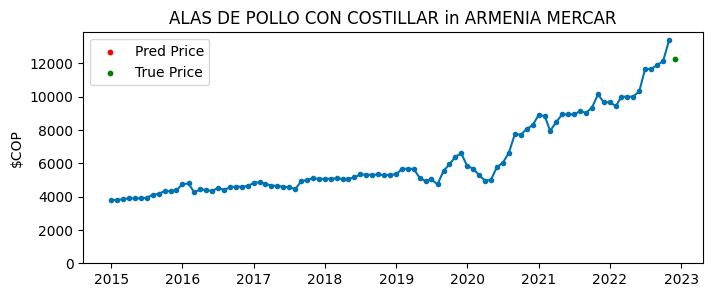

In [16]:
plt.figure(figsize=(8,3))
plt.plot(filtered_dataset['mean_price'].iloc[:-1], marker = '.')
plt.ylim(bottom=0)
plt.title(f"{mape_df['product'].iloc[-1].upper()} in {mape_df['market'].iloc[-1].upper()}")
plt.ylabel("$COP")
plt.scatter([filtered_dataset['mean_price'].index[-1]], [pred], s = 10, color = 'r', label = 'Pred Price')
plt.scatter([filtered_dataset['mean_price'].index[-1]], [true], s = 10, color = 'g', label = 'True Price')
plt.legend()
plt.show()

#### Individual MAPE Distribution

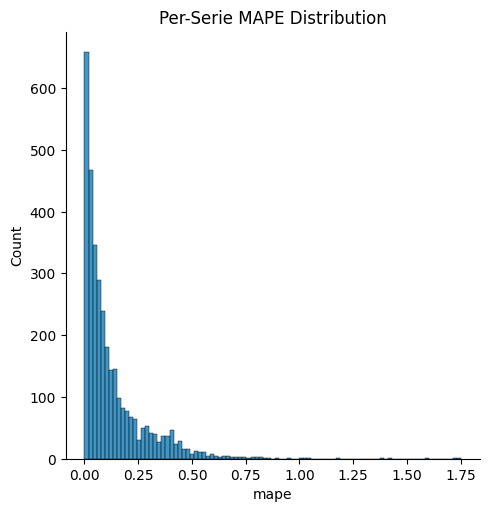

In [17]:
sns.displot(mape_df['mape'])
plt.title('Per-Serie MAPE Distribution')
plt.show()

#### Aggregate Descriptions of MAPE Errors

In [18]:
mape_desc = mape_df['mape'].describe().apply(lambda x:np.round(x, 3)).to_dict()

In [22]:
mape_desc = {'mape_'+key: value for key,value in mape_desc.items() if key != 'count'}

In [23]:
mape_desc

{'mape_mean': 0.127,
 'mape_std': 0.155,
 'mape_min': 0.0,
 'mape_25%': 0.026,
 'mape_50%': 0.071,
 'mape_75%': 0.168,
 'mape_max': 1.752}

In [20]:
print("Aggregate MAPE =", mape_desc['mean'])

Aggregate MAPE = 0.127
